## Bayesian Neural Networks in Keras and TensorFlow 2.0

In [1]:
#! . activate base
#!pip install tensorflow==2.0.0b1 --user
#!pip install tfp_nightly --user
#!python -m ipykernel install --name tf_prob --user

In [2]:
#TODO: PUT RANDOM SEED FOR RESULT SECURING IN DEMOS
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

%matplotlib inline

/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/u30073/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
print('TensorFlow version (expected = 2.0.0-beta1):', tf.__version__)
print('TensorFlow Probability version (expected = 0.9.0-dev20190912):', tfp.__version__)

TensorFlow version (expected = 2.0.0-beta1): 2.0.0-beta1
TensorFlow Probability version (expected = 0.9.0-dev20190912): 0.9.0-dev20190913


In [4]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

## We are all set up, lets go!

We are using CIFAR10 dataset!
X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 10)


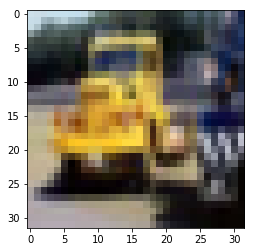

In [5]:
"""
first, we load the dataset. We are trying to do it first with CIFAR
I've found this snippet somewhere in github
"""

#as we have 10 classes, I'm setting class number to 10
class_nmr = 10

print('We are using CIFAR10 dataset!')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
#X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, class_nmr)
y_test = tf.keras.utils.to_categorical(y_test, class_nmr)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[1026, :, :, :])

In [10]:
def build_bayesian_bcnn_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

In [11]:
"""
here we are just instancing our model and setting up an Optimizer
"""
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [12]:
"""
this is our loss function: a sum of KL Divergence and Softmax crossentropy
We use the @tf.function annotation becuase of TF2.0, and need no placeholders
we get each loss and return its mean
"""

@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [13]:
"""
this is our train step with tf2.0, very ellegant:
We do our flow of the tensors over the model recording its gradientes
Then, our gradient tape to give us a list of the gradients of each parameter in relation of the loss
we dan ask our previously instanced optimizer to apply those gradients to the variable
It is cool to see that it works even with TensorFlow probability- probabilistic layers parameters
"""
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(y_train, axis=1))

In [11]:
"""
in our train step we can see that it lasts more tha na normal CNN to converge
on the other side, we can have the confidence interval for our predictions, which are 
wonderful in terms of taking sensitive predictions
"""
times = []
for i in range(30):
    tic = time.time()
    loss = train_step(X_train, y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, y_train)
    tac = time.time()
    train_time = tac-tic
    times.append(train_time)
    print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, time: {:7.3f}".format(i, loss, acc, train_time))

Epoch: 0: loss =  14.481 , accuracy =   0.168, time:   9.677
Epoch: 1: loss =  10.899 , accuracy =   0.183, time:   9.847
Epoch: 2: loss =   5.777 , accuracy =   0.205, time:   9.672
Epoch: 3: loss =   3.769 , accuracy =   0.186, time:   9.746
Epoch: 4: loss =   2.613 , accuracy =   0.267, time:   9.553
Epoch: 5: loss =   2.228 , accuracy =   0.344, time:   9.717
Epoch: 6: loss =   2.071 , accuracy =   0.357, time:   9.560
Epoch: 7: loss =   1.919 , accuracy =   0.399, time:   9.756
Epoch: 8: loss =   1.776 , accuracy =   0.531, time:   9.479
Epoch: 9: loss =   1.528 , accuracy =   0.643, time:   9.595
Epoch: 10: loss =   1.244 , accuracy =   0.668, time:  10.679
Epoch: 11: loss =   1.075 , accuracy =   0.699, time:   9.662
Epoch: 12: loss =   0.909 , accuracy =   0.748, time:   9.556
Epoch: 13: loss =   0.775 , accuracy =   0.775, time:   9.990
Epoch: 14: loss =   0.718 , accuracy =   0.794, time:   9.503
Epoch: 15: loss =   0.682 , accuracy =   0.820, time:   9.752
Epoch: 16: loss = 

In [12]:
### About the performance:

mean = np.mean(times)
std = np.std(times)
print("In TensorFlow 2.0.0b1 our train time mean was : {:7.3f}, with std : {:7.3f}".format(mean, std))

no_outlier = times[1:]
no_mean = np.mean(no_outlier)
no_std = np.std(no_outlier)
print("\nHowever, by removing the outlier 1st time, our train time mean was : {:7.3f}, with std : {:7.3f}".format(no_mean, no_std))
print("\nWe conclude TensorFlow 2 has a longer time to start its variables, but then does it faster than TF1.14 Intel Optimzied (see other notebook)")

In TensorFlow 2.0.0b1 our train time mean was :   9.673, with std :   0.219

However, by removing the outlier 1st time, our train time mean was :   9.673, with std :   0.223

We conclude TensorFlow 2 has a longer time to start its variables, but then does it faster than TF1.14 Intel Optimzied (see other notebook)


### Now we will illustrate our predictions and confidence intervals

Those illustrative functions were taken from https://github.com/zhulingchen/tfp-tutorial/ repo, which had the tutorial (in Keras) that did let me learn how to 

### Here we have some statistics on recognizable and unrecognizable images from MNIST:

In [13]:
n_mc_run = 50
med_prob_thres = 0.20

y_pred_logits_list = [bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9998
Unrecognizable samples: [6572 9655]
Test accuracy on MNIST (recognizable samples): 0.9164832966593318
Test accuracy on MNIST (unrecognizable samples): 0.0


### With this other snippet, we can plot the predict distribution of our network:

In [14]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

### This example is not recognizable:

True label of the test sample 6572: 1


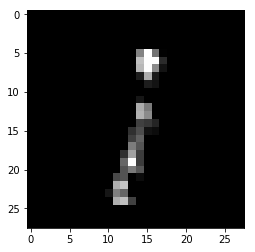

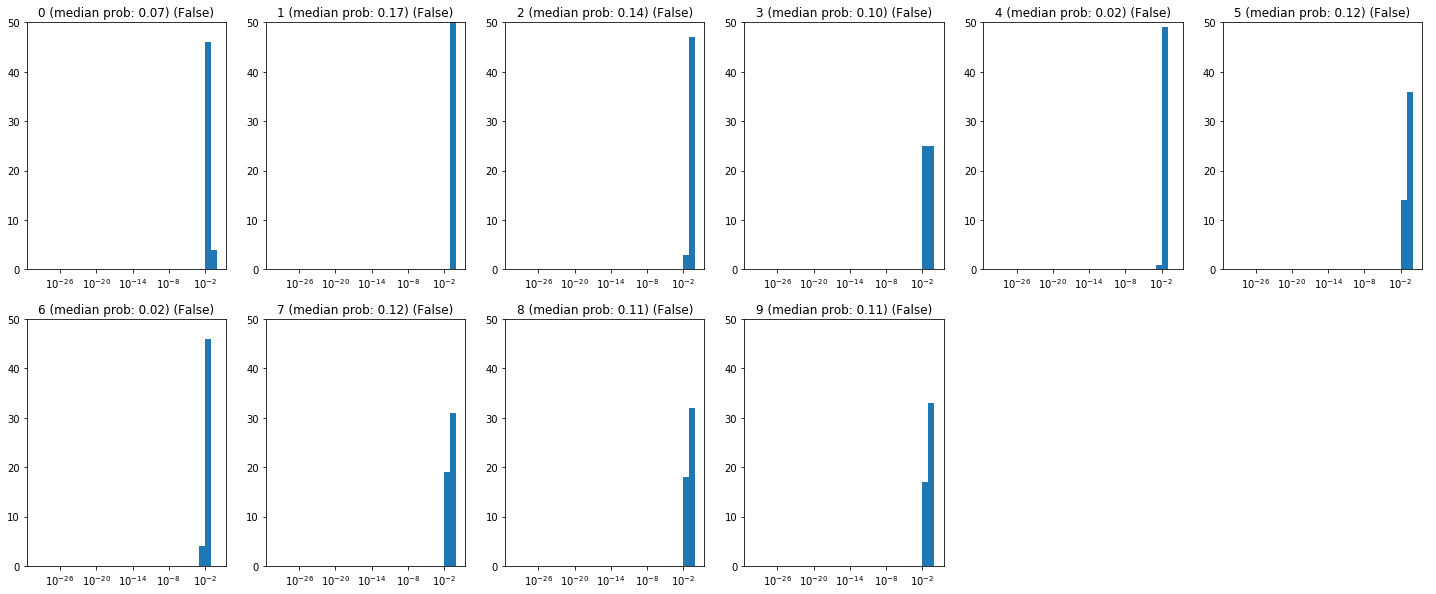

I don't know!
True label of the test sample 9655: 3


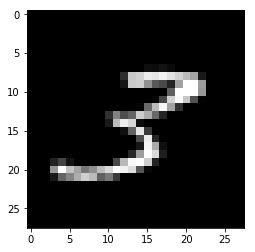

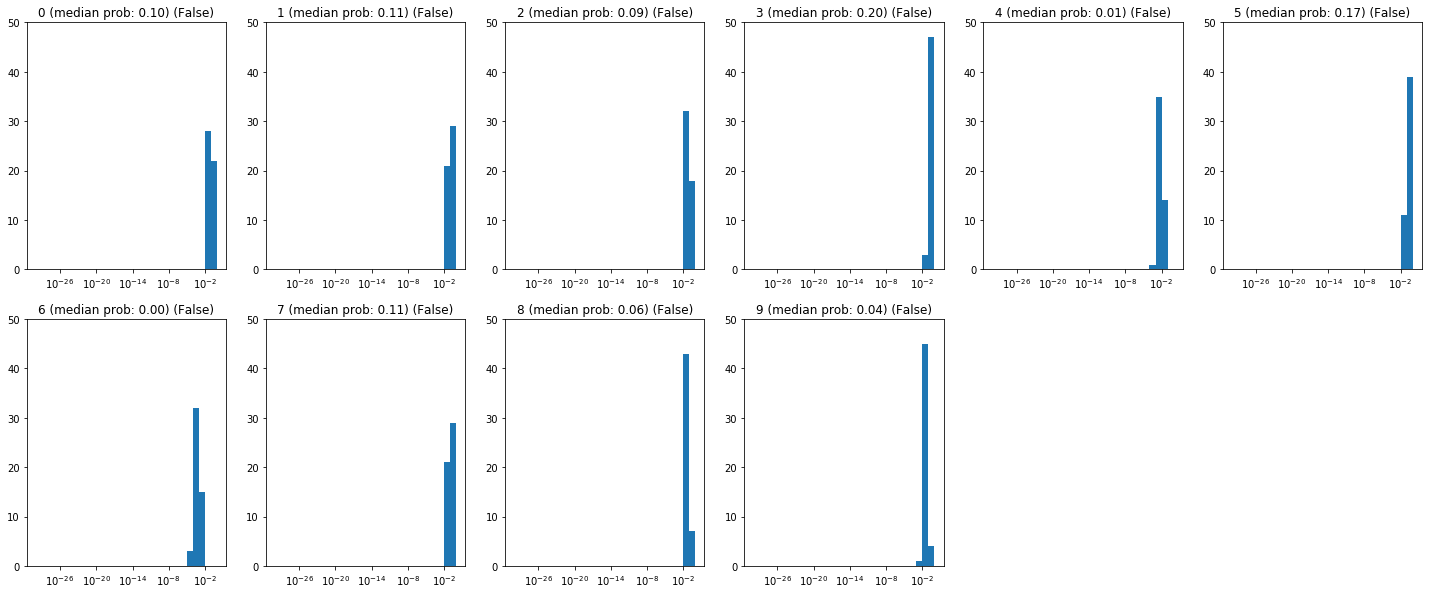

I don't know!


In [15]:
for idx in np.where(idx_invalid)[0]:
    plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

    plot_pred_hist(y_pred_prob_all[idx], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

    if any(y_pred[idx]):
        print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
    else:
        print("I don't know!")

### A recognizable one:

True label of the test sample 0: 7


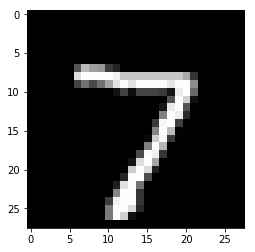

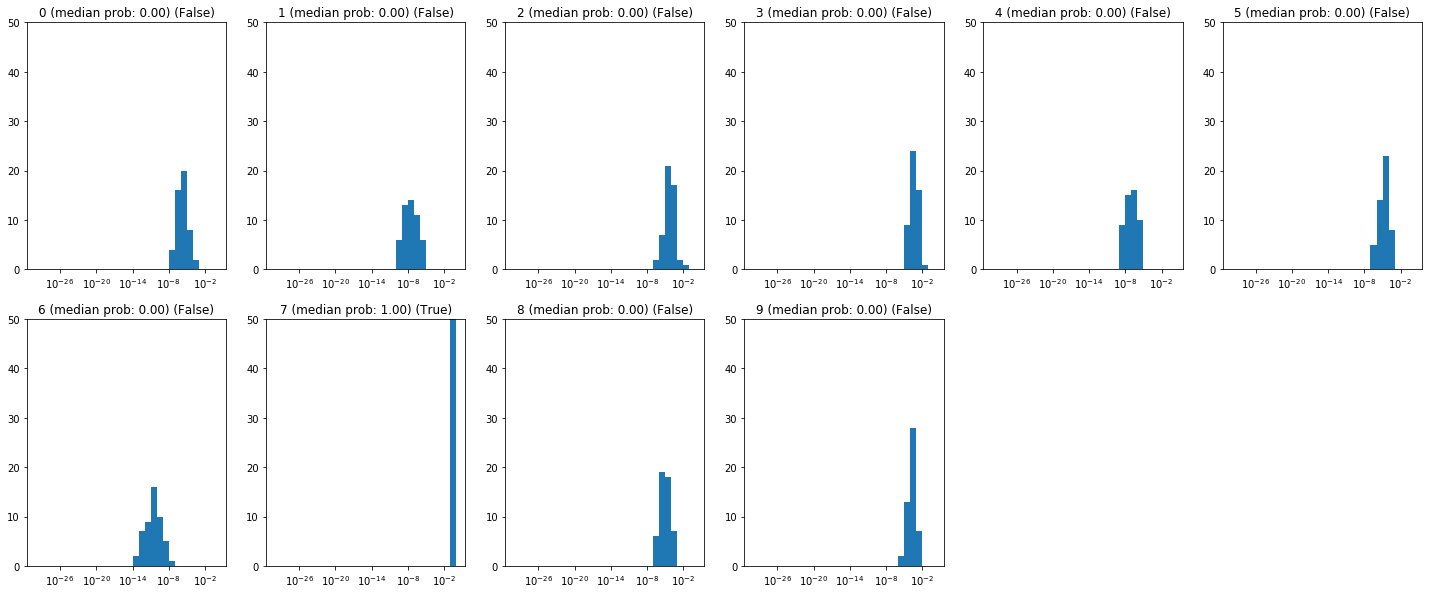

Predicted label of the test sample 9655: 7


In [16]:
plt.imshow(X_test[0, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(y_test[0], axis=-1)))

plot_pred_hist(y_pred_prob_all[0], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[0]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[0], axis=-1)))
else:
    print("I don't know!")